# Exploring ACTS data characteristics

In this notebook I'm now using ACTS cluster data for some exploratory analysis to try and answer some questions quantitatively:
- Numbers of tracks, numbers of hits on tracks
- Track density in the detector volumes and in local neighborhoods.

In [1]:
from __future__ import print_function

import ast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

## Utilities

### Data processing utilities

In [2]:
def load_data(file_name, columns):
    """Read the data into a pandas dataframe"""
    print('Loading', file_name)
    with open(file_name) as f:
        df = pd.DataFrame(
            [ast.literal_eval(line) for line in f
             if line.strip() and line[0] != "#"])
    # Rename the columns to something useful
    df.columns = columns
    return df

def load_data_events(file_name, columns, print_freq=100):
    """
    Load data from file into a dataframe.
    This function will detect each event and adds an evtid column.
    """
    dfs = []
    print('Loading', file_name)
    with open(file_name) as f:
        event_lines = []
        # Loop over lines in the file
        for line in f:
            # Add to current event
            if line.strip() and line[0] != '#':
                event_lines.append(ast.literal_eval(line))
            
            # Finalize a complete event
            elif len(event_lines) > 0:
                evtid = len(dfs)
                if (evtid % print_freq) == 0:
                    print('Finished event', evtid)
                df = pd.DataFrame(event_lines)
                df.columns = columns
                df['evtid'] = evtid
                dfs.append(df)
                event_lines = []
        # Verify there are no leftovers (otherwise fix this code)
        assert len(event_lines) == 0
    
    # Concatenate the events together into one DataFrame
    return pd.concat(dfs, ignore_index=True)

def process_hits_data(df, copy_keys=['evtid', 'hitid', 'barcode', 'volid', 'layid']):
    """Split columns and calculate some derived variables"""
    hits = pd.DataFrame(df[copy_keys])
    hits['x'] = df.gpos.apply(lambda pos: pos[0])
    hits['y'] = df.gpos.apply(lambda pos: pos[1])
    hits['z'] = df.gpos.apply(lambda pos: pos[2])
    hits['r'] = np.sqrt(hits.x**2 + hits.y**2)
    hits['phi'] = np.arctan2(hits.y, hits.x)
    hits['theta'] = np.arctan2(hits.r, hits.z)
    hits['eta'] = -1. * np.log(np.tan(hits.theta / 2.))
    return hits

def process_particles_data(df, copy_keys=['evtid', 'barcode', 'q']):
    """Split columns and calculate some derived variables"""
    particles = pd.DataFrame(df[copy_keys])
    particles['vx'] = df.vpos.apply(lambda pos: pos[0])
    particles['vy'] = df.vpos.apply(lambda pos: pos[1])
    particles['vz'] = df.vpos.apply(lambda pos: pos[2])
    particles['p'] = df.kin.apply(lambda kin: kin[0])
    particles['theta'] = df.kin.apply(lambda kin: kin[1])
    particles['phi'] = df.kin.apply(lambda kin: kin[2])
    particles['pt'] = particles.p * np.sin(particles.theta)
    particles['eta'] = -1. * np.log(np.tan(particles.theta / 2.))
    return particles

### Visualization utilities

In [3]:
def draw_hist(a, xlabel=None, **kwargs):
    plt.hist(a, **kwargs)
    if xlabel is not None:
        plt.xlabel(xlabel)

def draw_scatter(x, y, s=1, marker='.', xlabel=None, ylabel=None, label=None, **kwargs):
    plt.scatter(x, y, s=s, marker=marker, label=label, **kwargs)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

## Load the data

For now we're playing with some low-occupancy, "easy" data, with pileup mu=10 and a 1 GeV pt cut.

In [4]:
# Input file path(s)
hits_file_name = '/Users/sfarrell/Atlas/TrackML/acts_dev/prod_mu10_pt1000_2017_07_28/Clusters.csv'
particles_file_name = '/Users/sfarrell/Atlas/TrackML/acts_dev/prod_mu10_pt1000_2017_07_28/Particles.csv'

#hits_file_name = 'prod_mu10_2017_07_27/Clusters.csv'
#particles_file_name = 'prod_mu10_2017_07_27/Particles.csv'

In [5]:
# Read the data
hits_columns = ['hitid', 'barcode', 'volid', 'layid',
                'lpos', 'lerr', 'gpos',
                'chans', 'dir', 'direrr']
hits_full = load_data_events(hits_file_name, columns=hits_columns)
# Extract out the variables we're interested in
hits = process_hits_data(hits_full)

Loading /Users/sfarrell/Atlas/TrackML/acts_dev/prod_mu10_pt1000_2017_07_28/Clusters.csv
Finished event 0
Finished event 100
Finished event 200
Finished event 300
Finished event 400
Finished event 500
Finished event 600
Finished event 700
Finished event 800
Finished event 900


In [6]:
particles_columns = ['barcode', 'vpos', 'kin', 'q']
particles_full = load_data_events(particles_file_name, columns=particles_columns)
particles = process_particles_data(particles_full)

Loading /Users/sfarrell/Atlas/TrackML/acts_dev/prod_mu10_pt1000_2017_07_28/Particles.csv
Finished event 0
Finished event 100
Finished event 200
Finished event 300
Finished event 400
Finished event 500
Finished event 600
Finished event 700
Finished event 800
Finished event 900


In [7]:
print('Processed hits data shape:', hits.shape)
print('First 5 entries:')
hits.head()

Processed hits data shape: (521806, 12)
First 5 entries:


,evtid,hitid,barcode,volid,layid,x,y,z,r,phi,theta,eta
0,0,1,22519097648480256,7,6,-132.4640,102.75000,-962.0,167.643293,2.481856,2.969060,-2.447830
1,0,2,9013658885554176,7,6,-158.5980,9.70996,-958.0,158.894962,3.080445,2.977228,-2.496559
2,0,3,31530763669209088,7,8,-166.5990,-2.62192,-822.0,166.619630,-3.125856,2.941602,-2.299291
3,0,4,22519166367956992,7,8,10.0106,167.26700,-822.0,167.566290,1.511020,2.940496,-2.293739
4,0,5,22519097648480256,7,8,-112.1860,86.10680,-822.0,141.421638,2.486963,2.971215,-2.460461


In [8]:
print('Processed particle data shape:', particles.shape)
print('First few entries:')
particles.head()

Processed particle data shape: (42843, 11)
First few entries:


,evtid,barcode,q,vx,vy,vz,p,theta,phi,pt,eta
0,0,9007611571601408,-1,-0.004985,0.004099,71.3403,2.25170,2.239290,2.944980,1.767035,-0.724688
1,0,9008298766368768,-1,-0.004985,0.004099,71.3403,5.85017,2.835510,0.361795,1.762806,-1.869197
2,0,9009879314333696,-1,-0.004985,0.004099,71.3403,4.45530,0.232761,1.373470,1.027682,2.146361
3,0,9010085472763904,1,-0.004985,0.004099,71.3403,4.50735,0.452473,0.290055,1.970573,1.468907
4,0,9010154192240640,-1,-0.004985,0.004099,71.3403,3.63076,0.297333,-0.198506,1.063708,1.898644


## Event visualizations
Visualize the tracks and hits in one event.

In [123]:
# Choose an event to play with
ievt = 2
evt_hits = hits[hits.evtid == ievt]
evt_pids = np.unique(evt_hits.barcode)

### Scatter plots - whole detector

<IPython.core.display.Javascript object>


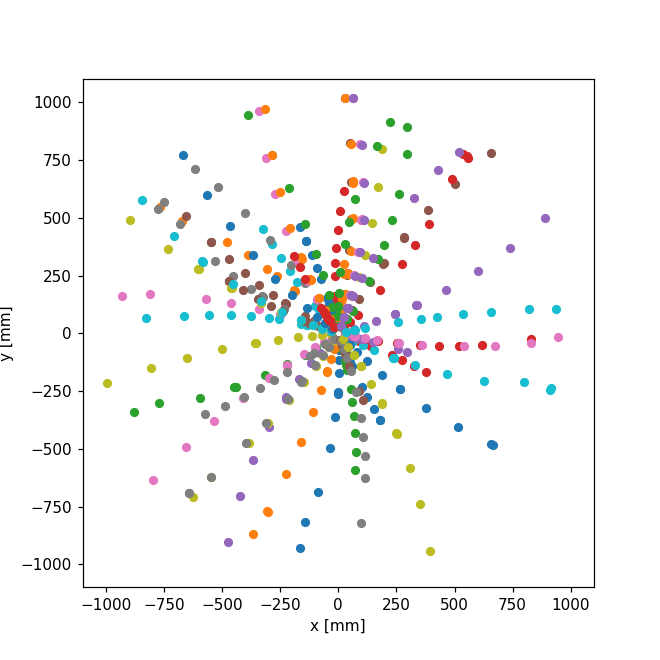

<IPython.core.display.Javascript object>


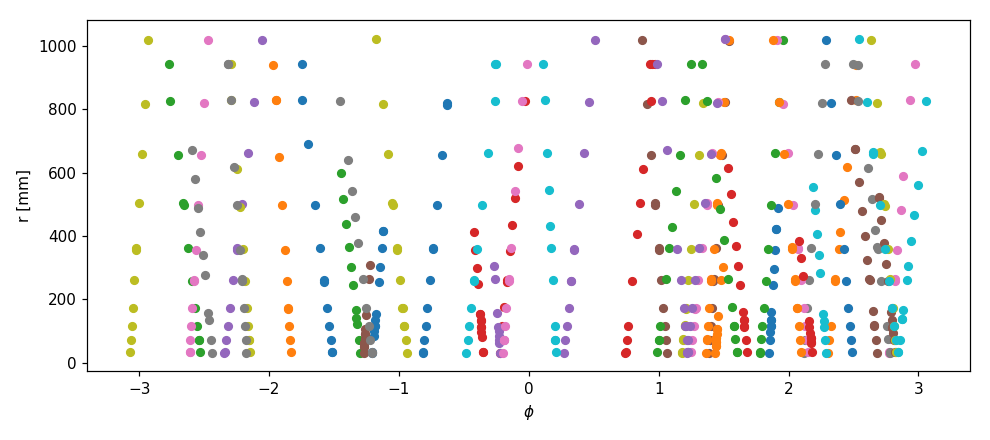

<IPython.core.display.Javascript object>


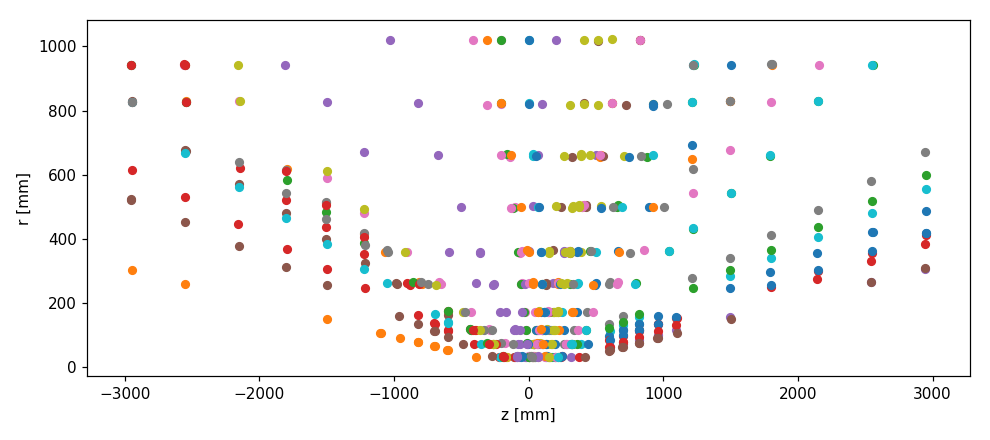

In [124]:
plt.figure(figsize=(6,6))
for pid in evt_pids:
    par_hits = evt_hits[evt_hits.barcode == pid]
    draw_scatter(par_hits.x, par_hits.y, s=100)
plt.xlim((-1100, 1100))
plt.ylim((-1100, 1100))
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

plt.figure(figsize=(9,4))
for pid in evt_pids:
    par_hits = evt_hits[evt_hits.barcode == pid]
    draw_scatter(par_hits.phi, par_hits.r, s=100)
plt.xlabel('$\phi$')
plt.ylabel('r [mm]')
plt.tight_layout()

plt.figure(figsize=(9,4))
for pid in evt_pids:
    par_hits = evt_hits[evt_hits.barcode == pid]
    draw_scatter(par_hits.z, par_hits.r, s=100)
plt.xlabel('z [mm]')
plt.ylabel('r [mm]')
plt.tight_layout()

### Scatter plots - individual detector layers

<IPython.core.display.Javascript object>


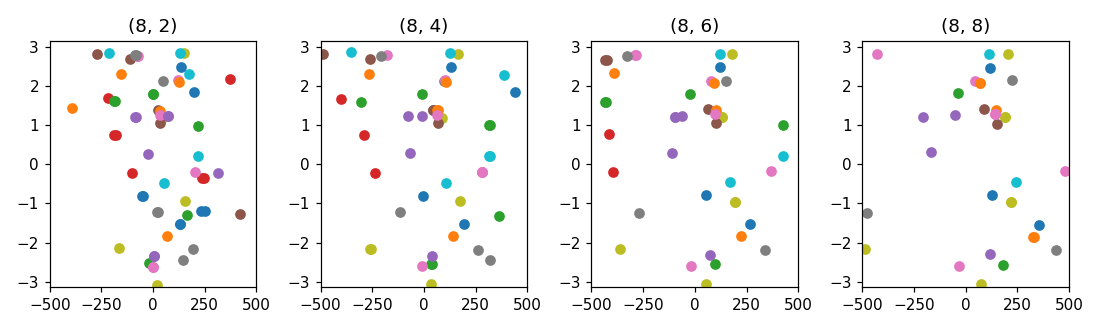

<IPython.core.display.Javascript object>


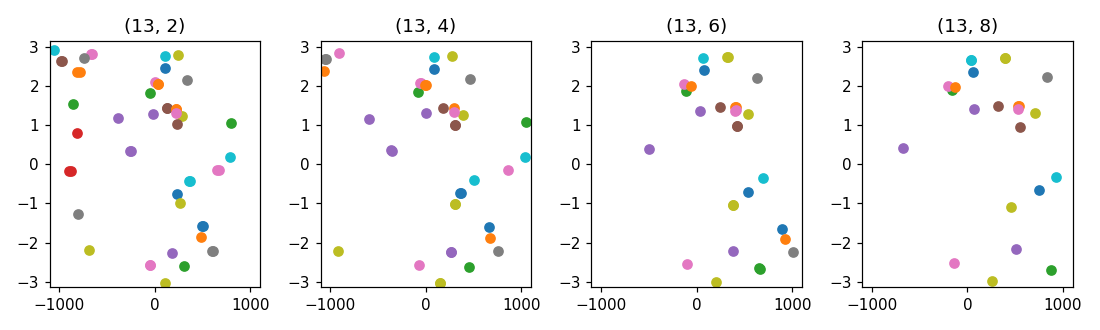

<IPython.core.display.Javascript object>


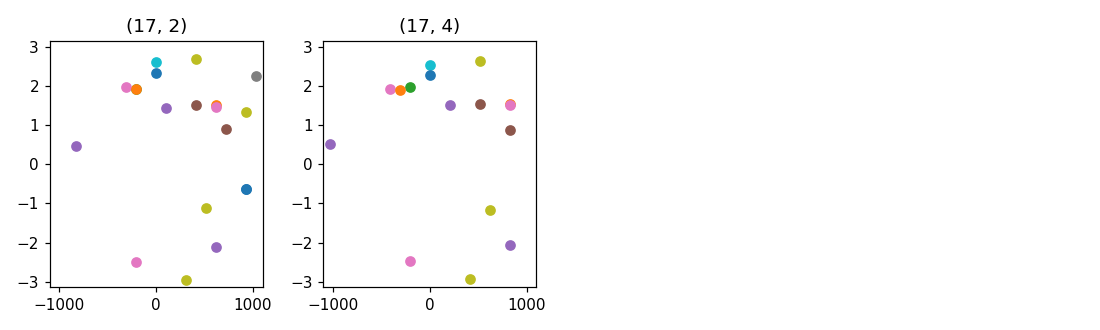

In [125]:
# Inner barrel layers
plt.figure(figsize=(10,3))
vol_hits = evt_hits[evt_hits.volid == 8]
for lid in [2, 4, 6, 8]:
    plt.subplot(1, 4, lid/2)
    lay_hits = vol_hits[vol_hits.layid == lid]
    for pid in evt_pids:
        par_hits = lay_hits[lay_hits.barcode == pid]
        plt.scatter(par_hits.z, par_hits.phi)
        plt.xlim((-500, 500))
        plt.ylim((-np.pi, np.pi))
        plt.title((8,lid))
plt.tight_layout()

# Middle barrel layers
plt.figure(figsize=(10,3))
vol_hits = evt_hits[evt_hits.volid == 13]
for lid in [2, 4, 6, 8]:
    plt.subplot(1, 4, lid/2)
    lay_hits = vol_hits[vol_hits.layid == lid]
    for pid in evt_pids:
        par_hits = lay_hits[lay_hits.barcode == pid]
        plt.scatter(par_hits.z, par_hits.phi)
        plt.xlim((-1100, 1100))
        plt.ylim((-np.pi, np.pi))
        plt.title((13,lid))
plt.tight_layout()

# Outer barrel layers
plt.figure(figsize=(10,3))
vol_hits = evt_hits[evt_hits.volid == 17]
for lid in [2, 4]:
    plt.subplot(1, 4, lid/2)
    lay_hits = vol_hits[vol_hits.layid == lid]
    for pid in evt_pids:
        par_hits = lay_hits[lay_hits.barcode == pid]
        plt.scatter(par_hits.z, par_hits.phi)
        plt.xlim((-1100, 1100))
        plt.ylim((-np.pi, np.pi))
        plt.title((17,lid))
plt.tight_layout()

## Event distributions

<IPython.core.display.Javascript object>


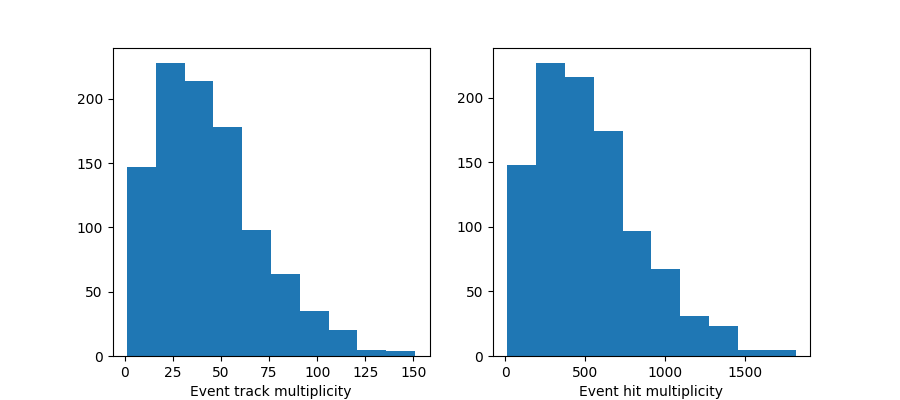

In [12]:
# Track and hit multiplicities
plt.figure(figsize=(9,4))
plt.subplot(121)
draw_hist(particles.groupby('evtid').size(), xlabel='Event track multiplicity')
plt.subplot(122)
draw_hist(hits.groupby('evtid').size(), xlabel='Event hit multiplicity')

Let's make some histograms of the hit counts in each detector volume. How about I use one plot for a volume, and show each histogram superimposed for each layer.

<IPython.core.display.Javascript object>


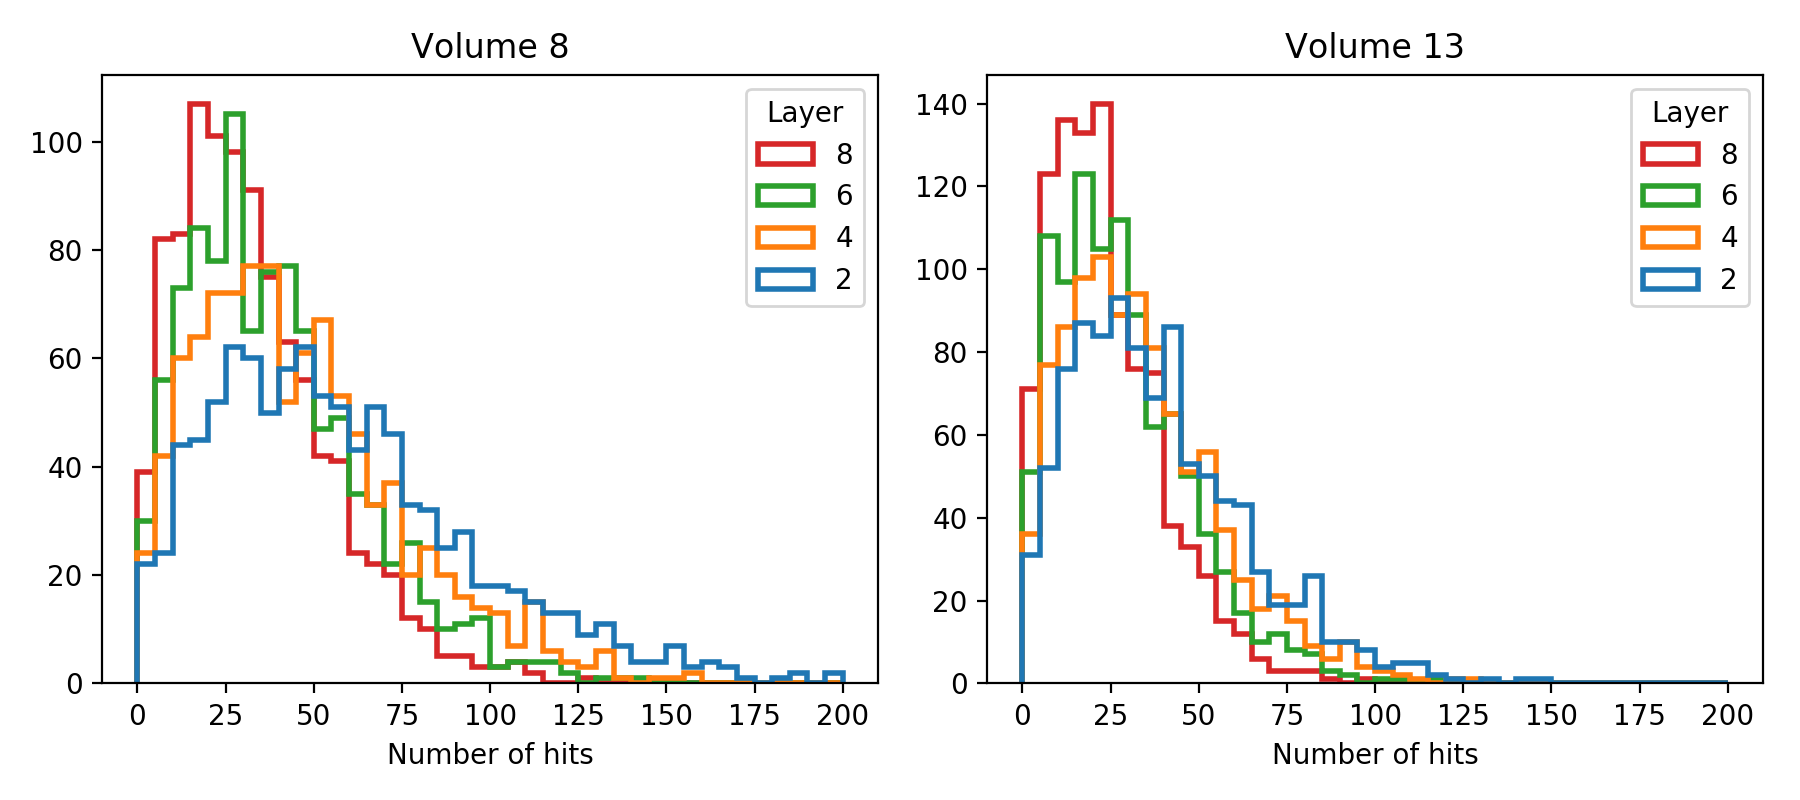

In [116]:
plt.figure(figsize=(9,4))

plt.subplot(121)
vol_hits = hits[hits.volid == 8]
counts = []
layers = []
for lay, lay_hits in vol_hits.groupby('layid'):
    counts.append(lay_hits.groupby('evtid').size())
    layers.append(lay)

draw_hist(counts, range=(0,200), bins=40,
          histtype='step', alpha=1, linewidth=2,
          label=layers, xlabel='Number of hits')
plt.legend(loc=0, title='Layer')
plt.title('Volume 8')

plt.subplot(122)
vol_hits = hits[hits.volid == 13]
counts = []
layers = []
for lay, lay_hits in vol_hits.groupby('layid'):
    counts.append(lay_hits.groupby('evtid').size())
    layers.append(lay)

draw_hist(counts, range=(0,200), bins=40,
          histtype='step', alpha=1, linewidth=2,
          label=layers, xlabel='Number of hits')
plt.legend(loc=0, title='Layer')
plt.title('Volume 13')

plt.tight_layout()

In [38]:
# I can construct a series of hit counts indexed by event, volume, and layer,
# but this data structure is kinda difficult to work with, so I'm not sure
# it's worthwhile enough. Let's leave this here as a reference for now
hit_counts = hits.groupby(['evtid', 'volid', 'layid']).size()
hit_counts.head()

evtid  volid  layid
0      7      6         2
              8         7
              10        8
              12        7
       8      2        39
dtype: int64

## Track distributions

Let's now look at things like the number of hits on a track, the kinematics, and the track shapes.

To calculate the dphi, I need to pick the first hit and the last hit.

In [13]:
def df_calc_dphi(df):
    """Within a group (a particle) of hits, calculate
    the absolute change in phi between the first and last hit,
    as sorted in cylindrical r.
    """
    phi = df.sort_values('r').phi.values
    dphi = np.abs(phi[-1] - phi[0])
    if dphi > np.pi:
        dphi = 2*np.pi - dphi
    return dphi

par_groups = hits.groupby(['evtid', 'barcode'])
nhits = par_groups.size()
dphi = par_groups.apply(df_calc_dphi).values
deta = par_groups.eta.max() - par_groups.eta.min()

<IPython.core.display.Javascript object>


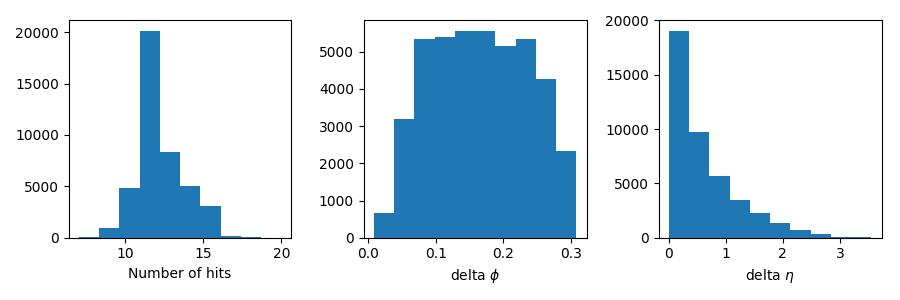

In [14]:
plt.figure(figsize=(9,3))
plt.subplot(131)
draw_hist(nhits, xlabel='Number of hits')
plt.subplot(132)
draw_hist(dphi, log=False, xlabel='delta $\phi$')
plt.subplot(133)
draw_hist(deta, xlabel='delta $\eta$')
plt.tight_layout()

<IPython.core.display.Javascript object>


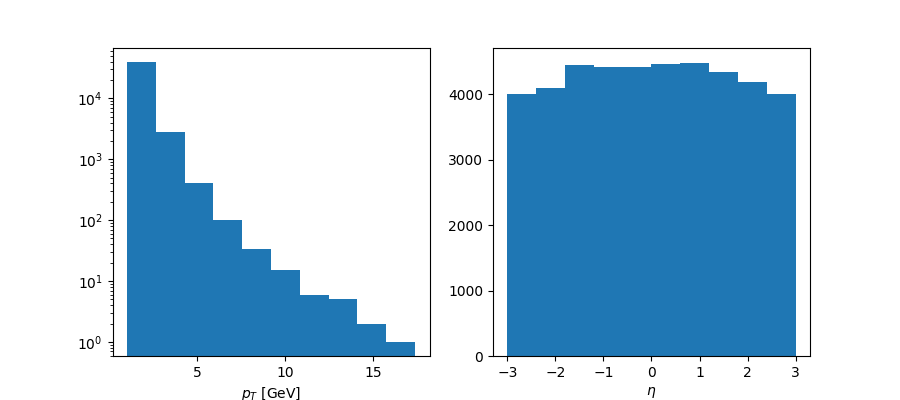

In [15]:
plt.figure(figsize=(9,4))
plt.subplot(121)
draw_hist(particles.pt, log=True, xlabel='$p_T$ [GeV]')
plt.subplot(122)
draw_hist(particles.eta, xlabel='$\eta$')

In [16]:
def calc_dphi(phi1, phi2):
    dphi = np.abs(phi1 - phi2)
    idx = dphi > np.pi
    dphi[idx] = 2*np.pi - dphi[idx]
    return dphi

def calc_dR(eta1, eta2, phi1, phi2):
    deta = np.abs(eta1 - eta2)
    dphi = calc_dphi(phi1, phi2)
    return np.sqrt(deta*deta + dphi*dphi)

In [17]:
# Let's calculate the delta-phi between hits and their true particle phi.
# It should roughly correspond to how much tracks deviate in phi from their initial value.
# I should be able to accomplish this with a join.
hp = hits.merge(particles, on=['evtid'], how='inner', suffixes=['_hit', '_par'])
sig_hp = hp[hp.barcode_hit == hp.barcode_par]
bkg_hp = hp[hp.barcode_hit != hp.barcode_par]

sig_dphi = calc_dphi(sig_hp.phi_hit, sig_hp.phi_par)
sig_deta = np.abs(sig_hp.eta_hit - sig_hp.eta_par)
sig_dR = calc_dR(sig_hp.eta_hit, sig_hp.eta_par, sig_hp.phi_hit, sig_hp.phi_par)

bkg_dphi = calc_dphi(bkg_hp.phi_hit, bkg_hp.phi_par)
bkg_deta = np.abs(bkg_hp.eta_hit - bkg_hp.eta_par)
bkg_dR = calc_dR(bkg_hp.eta_hit, bkg_hp.eta_par, bkg_hp.phi_hit, bkg_hp.phi_par)

<IPython.core.display.Javascript object>


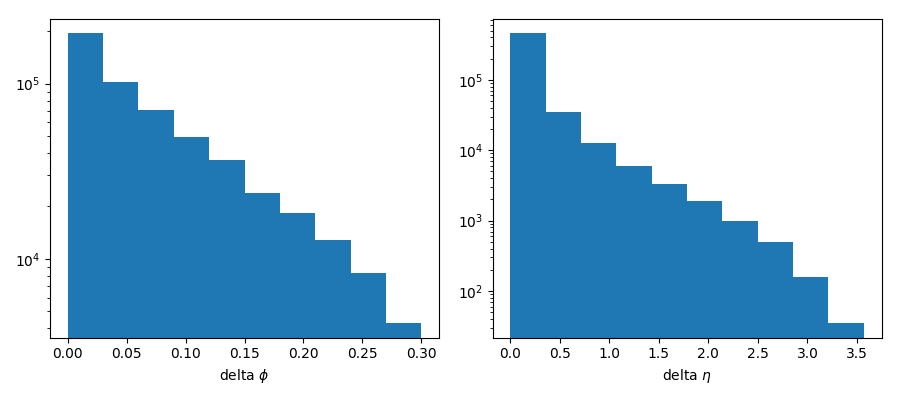

In [18]:
plt.figure(figsize=(9,4))
plt.subplot(121)
draw_hist(sig_dphi, log=True, range=(0, 0.3), xlabel='delta $\phi$')
plt.subplot(122)
draw_hist(sig_deta, log=True, xlabel='delta $\eta$')
plt.tight_layout()

<IPython.core.display.Javascript object>


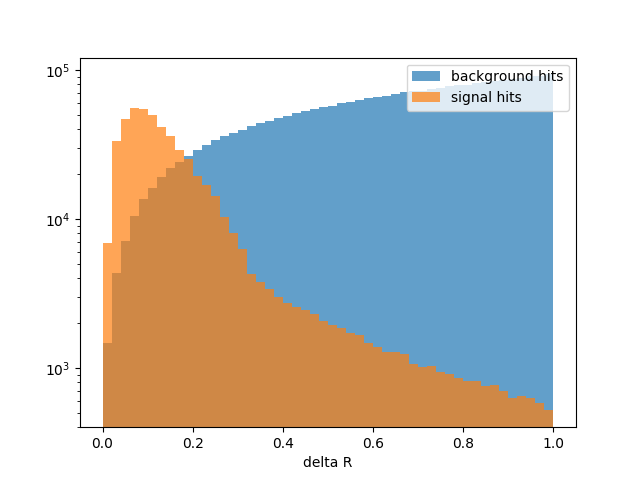

In [24]:
# To understand 
plt.figure()
kwargs = dict(log=True, range=(0, 1), bins=50, alpha=0.7,
              xlabel='delta R')
draw_hist(bkg_dR, label='background hits', **kwargs)
draw_hist(sig_dR, label='signal hits', **kwargs)
plt.legend(loc=1);

## Track densities

What exactly do we want to plot here?
We want to learn something about the neighborhood around a track.
We want to know how many other track hits are in the vicinity, relative to the usual spread of a track itself.

Maybe what I actually want is to show the above histograms drawn along with the other-particle hits on the same axis.
Let's start by trying to make the equivalent plot as above but for hits from different particles.

To calculate this, maybe I can do some kind of equivalent merge which joins on the evtid but inverts the barcode match.

In [135]:
few_particles = particles.sample(5)

In [138]:
hp = few_particles.merge(hits, on='evtid', suffixes=['_par', '_hits'])
bkg = hp[hp.barcode_par != hp.barcode_hits]
bkg_dphi = calc_dphi(bkg.phi_hits, bkg.phi_par)

<IPython.core.display.Javascript object>


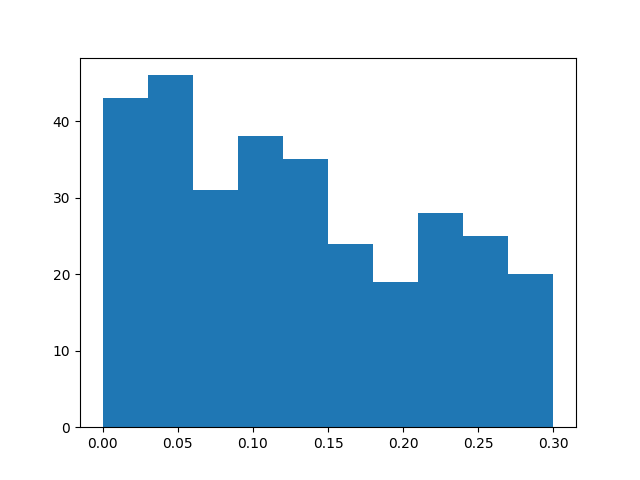

In [141]:
plt.figure()
draw_hist(bkg_dphi, range=(0, 0.3))

## Visualizing tracks
Now let's look at the regions around some tracks to get an intuitive sense of the track density.

In [20]:
pid = np.random.choice(evt_pids)
par_hits = evt_hits[evt_hits.barcode == pid]
r_window = (0, 1200)
phi_window = par_hits.phi.min() - 0.2, par_hits.phi.max() + 0.2
z_window = par_hits.z.min(), par_hits.z.max()
other_hits = evt_hits[(evt_hits.barcode != pid) &
                      (evt_hits.phi > phi_window[0]) &
                      (evt_hits.phi < phi_window[1])]

<IPython.core.display.Javascript object>


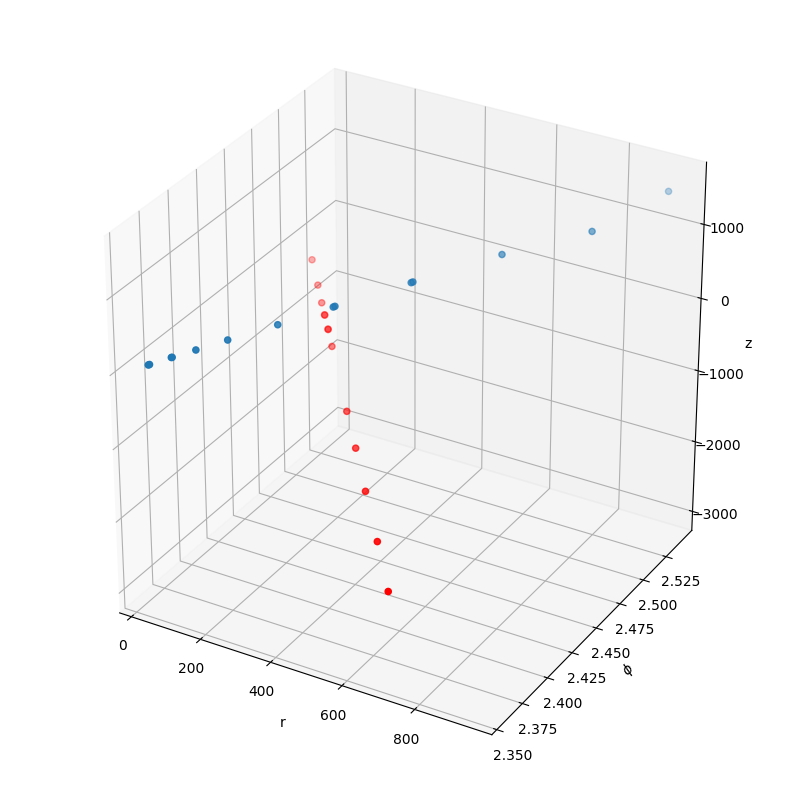

In [21]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(par_hits.r, par_hits.phi, par_hits.z, s=20, c='r')
ax.scatter(other_hits.r, other_hits.phi, other_hits.z)
ax.set_xlabel('r')
ax.set_ylabel('$\phi$')
ax.set_zlabel('z')
#ax.set_xlim((0, par_hits.r.max()))
#ax.set_ylim3d((par_hits.phi.min(), par_hits.phi.max()))
plt.tight_layout()